# PCA Cleaning Applied to MeerKAT data
This notebook applies PCA as a foreground cleaning method to the MeerKAT data {where is this data from? description of this?}. This notebook is adapated from the notebook MeerKAT.GPR.ipynb {credit for this?} and the method of PCA used therein, is also applied here to confirm that my PCA functions are working properly. 

In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
from pylab import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors

import scipy.linalg as lng
import PCA  #my PCA method

import sys
sys.path.append('GPR4-MeerKAT/scripts/')
import BSS_isabella as BSS
import utils
import pk_scripts

from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord

import GPy

from gpr4im import pk_tools as pk
from gpr4im import fg_tools as fg

In [24]:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

In [25]:
# for plotting the true x,y scales
def get_extent(ra,dec):
    deltara  = abs(ra[1]-ra[0])
    deltadec = abs(dec[1]-dec[0])
    extent=[np.min(ra)-deltara,np.max(ra)+deltara,np.min(dec)-deltadec,np.max(dec)+deltadec]
    return extent
XLAB=r'${\rm R.A} (J2000) [^\circ]$'
YLAB=r'${\rm Dec} (J2000) [^\circ]$'

### Load in the Data

In [26]:
A, B = 550,800   #range of frequency 
nu_ch = utils.cal_freq(np.arange(A,B))  #makes a range of frequecnies
v_extent=[A,B,A,B]

In [27]:
Tsky_original = np.load('GPR4-MeerKAT/data/Tsky_band1.npz')['Tsky']

## flip Tsky for later convenience
print(np.shape(Tsky_original))
Tsky_original = np.moveaxis(Tsky_original,-1,0)
print(np.shape(Tsky_original))

with np.load('GPR4-MeerKAT/data/radec.npz') as data:
    ra_original = data['ra']
    dec_original = data['dec']
print(len(ra_original),len(dec_original))
## for plotting
extent_original = get_extent(ra_original,dec_original)

## if only the first 250 channels
Tsky_original = Tsky_original[:250]
print(np.shape(Tsky_original))

(133, 41, 500)
(500, 133, 41)
133 41
(250, 133, 41)


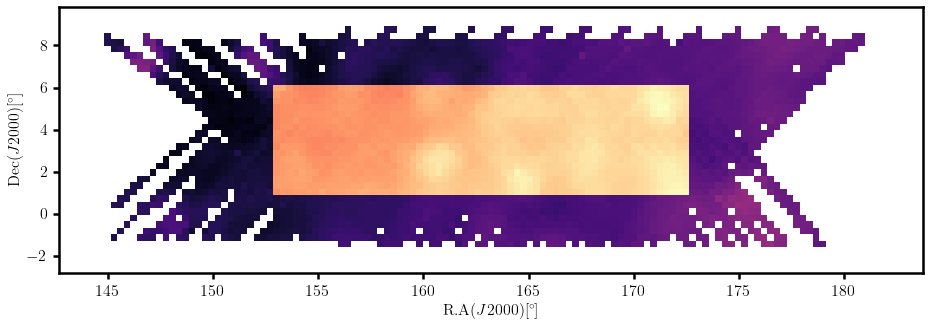

In [28]:
## read the small patch 
small_foot = np.load('GPR4-MeerKAT/data/mask_centralStrip.npy')

fig, ax = plt.subplots(1,1, figsize=(15, 5))
im = ax.imshow(Tsky_original[0].T+small_foot.T,extent=extent_original,origin='lower')
ax.set(xlabel=XLAB,ylabel=YLAB);

In [29]:
#apply cropping
Tsky = np.array([utils.crop_map(Tsky_original[j],Tsky_original[0],small_foot) for j in range(len(nu_ch))])

In [30]:
## new ra and dec arrys, and relative extent for plotting
ra, dec = utils.crop_radec(ra_original,dec_original,Tsky_original[0],small_foot)
extent = get_extent(ra,dec)

nchan,nx,ny = np.shape(Tsky)

## PCA

In [31]:
### set up PCA ###
nz = 250
N_fg = 30

BB = PCA.selection_matrix(nz,N_fg)

print(np.shape(Tsky))
Tsky_shaped = PCA.shaping(Tsky,xyz=False) #this is the sky data in the correct from for my function clean
dTsky = PCA.mean_centre(Tsky_shaped) #this is the sky data in the correct form for my function fg_est
AA,S = PCA.PCA(dTsky,BB)

(250, 64, 17)


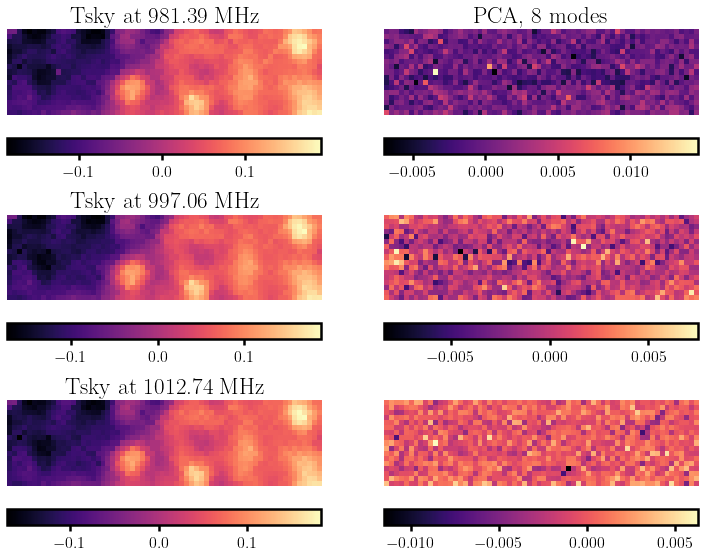

In [32]:
N_chosen = 8

A_tmp   =  np.copy(AA[:,:N_chosen]) 

fg_tmp = PCA.fg_est(dTsky,N_chosen)
res_tmp = PCA.clean(Tsky_shaped,fg_tmp)
res_tmp = PCA.shaping(res_tmp)

del A_tmp

fig, axes = plt.subplots(3, 2, figsize=(12, 9))

    
i=0
for ax,jj in zip(axes.flat,[50,125,200]):
    
    im = axes[i,0].imshow(Tsky[jj].T,origin='lower',extent=extent)
    axes[i,0].set(title=f'Tsky at {np.round(nu_ch[jj],2)} MHz')
    plt.colorbar(im,ax=axes[i,0],orientation='horizontal');

    im = axes[i,1].imshow(res_tmp[jj].T,origin='lower',extent=extent)
    plt.colorbar(im,ax=axes[i,1],orientation='horizontal');
    
    for k in range(2):
        axes[i,k].axis('off')
    
    i+=1

    
axes[0,1].set(title=f'PCA, {N_chosen} modes');
#fig.savefig('plots/meerkat-pca-cleaning.png')

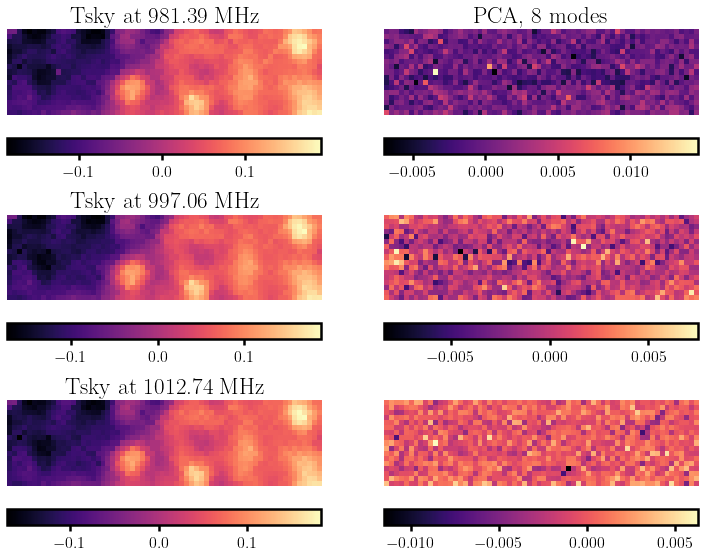

In [33]:
### PCA using BSS functions
A_pca = BSS.PCA_func(Tsky,30)

N_chosen = 8

A_tmp    =  np.copy(A_pca[:,:N_chosen]) 

res_tmp  = BSS.residuals(A_tmp,Tsky)

del A_tmp

fig, axes = plt.subplots(3, 2, figsize=(12, 9))

    
i=0
for ax,jj in zip(axes.flat,[50,125,200]):
    
    im = axes[i,0].imshow(Tsky[jj].T,origin='lower',extent=extent)
    axes[i,0].set(title=f'Tsky at {np.round(nu_ch[jj],2)} MHz')
    plt.colorbar(im,ax=axes[i,0],orientation='horizontal');

    im = axes[i,1].imshow(res_tmp[jj].T,origin='lower',extent=extent)
    plt.colorbar(im,ax=axes[i,1],orientation='horizontal');
    
    for k in range(2):
        axes[i,k].axis('off')
    
    i+=1

    
axes[0,1].set(title=f'PCA, {N_chosen} modes');

The mean percentage difference between the two above results is: 2.9e-10 %


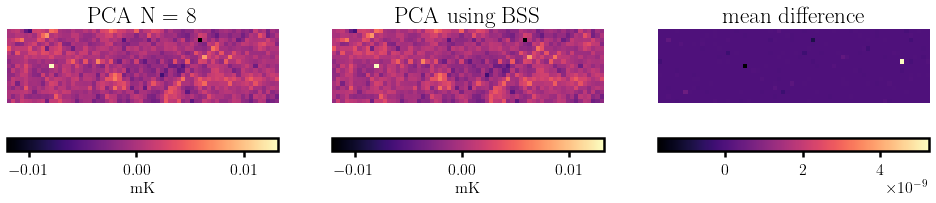

In [34]:
### COMPARISON BETWEEN THESE FUNCTIONS
## PCA residuals
A_tmp = BSS.PCA_func(Tsky,N_chosen)
res_tmp  = BSS.residuals(A_tmp,Tsky)

fg_tmp = PCA.fg_est(dTsky,N_chosen)
my_res_tmp = PCA.clean(Tsky_shaped,fg_tmp)
my_res_tmp = PCA.shaping(my_res_tmp) #reshape to match other

del A_tmp

tsky_all = np.mean(Tsky,0) 
my_res_all = np.mean(my_res_tmp,0)  
res_all = np.mean(res_tmp,0)

difference = (res_tmp - my_res_tmp)/res_tmp
difference_all = np.mean(difference,0)
## actual plotting
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

im = axes[0].imshow(my_res_all.T*1e3,origin='lower',extent=extent)
plt.colorbar(im,ax=axes[1],orientation='horizontal',label='mK');
axes[0].set(title=f'PCA N = {N_chosen}')

im = axes[1].imshow(res_all.T*1e3,origin='lower',extent=extent)
plt.colorbar(im,ax=axes[0],orientation='horizontal',label='mK');
axes[1].set(title=f'PCA using BSS')

im = axes[2].imshow(difference_all.T,origin='lower',extent=extent)
plt.colorbar(im,ax=axes[2],orientation='horizontal',label='');
axes[2].set(title=f'mean difference')

print(f'The mean percentage difference between the two above results is: {np.round(np.abs(np.mean(difference)*100),11)} %')

for k in range(3):
    axes[k].axis('off')


### Analysis of PCA residuals 

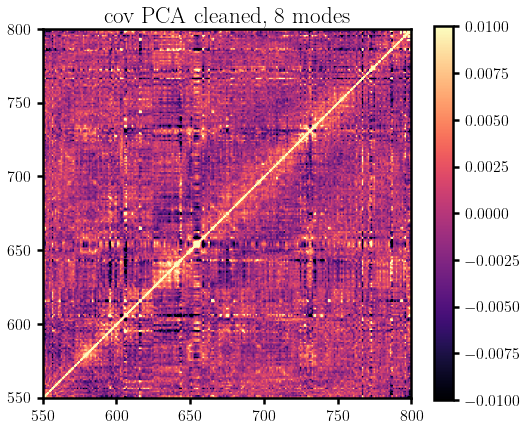

In [36]:
N_chosen = 8

fig, axes = plt.subplots(1, 1, figsize=(8,8))    
norm = mcolors.TwoSlopeNorm(vmin = -0.01,vmax = 0.01,vcenter=0)

#apply PCA
fg_tmp = PCA.fg_est(dTsky,N_chosen)
res_tmp = PCA.clean(Tsky_shaped,fg_tmp)
res_tmp = PCA.shaping(res_tmp)

dims = res_tmp.shape
dres_tmp = np.reshape(res_tmp,(dims[0],dims[1]*dims[2])) #reshape
cov_pca =  np.cov(dres_tmp)
cov_pca /= np.linalg.norm(cov_pca)

im = axes.imshow(cov_pca,origin='lower',extent=v_extent,norm=norm)
plt.colorbar(im,shrink= 0.8);
axes.set(title=f'cov PCA cleaned, {N_chosen} modes ');

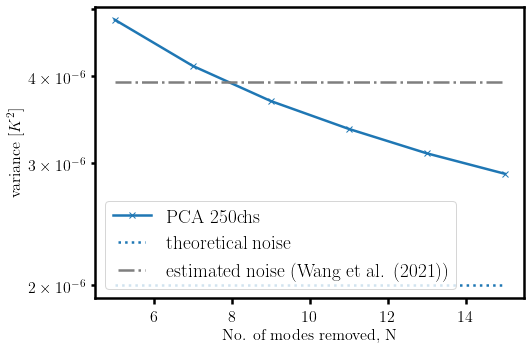

In [21]:
### TOTAL VARIANCE IN RESIDUALS ###
Nlist = np.arange(5,17)[::2]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
var_arr_pca_250 = []

for nn,i in zip(Nlist,range(len(Nlist))):
    N_chosen = nn
    
    fg_tmp = PCA.fg_est(dTsky,nn)
    res_tmp = PCA.clean(Tsky_shaped,fg_tmp)
    res_tmp = PCA.shaping(res_tmp)
    var_arr_pca_250.append(np.nanvar(res_tmp))
    
var_arr_pca_250 = np.array(var_arr_pca_250)    
ax.plot(Nlist,var_arr_pca_250,'-x',color='tab:blue',label='PCA 250chs')
ax.set(yscale='log')
plt.xlabel('No. of modes removed, N')
plt.ylabel('variance [$K^2$]')

ax.hlines(2e-6,Nlist[0],Nlist[-1],color='tab:blue',ls=':',label='theoretical noise')
ax.hlines(1.4*1.4*2e-6,Nlist[0],Nlist[-1],color='tab:gray',ls='-.',label='estimated noise (Wang et al. (2021))')
ax.legend()
fig.subplots_adjust(right=0.75);
plt.savefig('plots/total-variance-meerkat.png')

### Power Spectrum Analysis

In [29]:
## masks and dims

nz=nchan
W_HI = np.ones_like(Tsky) # Binary mask: 1 where pixel filled, 0 otherwise
W_HI[np.isnan(Tsky)] = 0
np.shape(W_HI)

x0,y0,z0,lx,ly,lz = pk_scripts.regrid(ra,dec,nu_ch)  #re-grid in comoving co-ords 
print(lx,ly,lz)
print(x0)

411.1068445572638 103.3051572537195 192.74025255449783
-204.60408201676157


In [30]:
### Read-in maps:
Opt_filename = 'GPR4-MeerKAT/data/'
countsfile = 'GPR4-MeerKAT/data/Nscan366_Npix_count_cube_p0.3d_sigma2.5_iter2.fits'
onIlifu_flag = False

## noise
print(A,B)
w_HI = pk_scripts.get_noise(countsfile,A,B,nz,cropped=True,small_foot=small_foot)

### WiggleZ galaxy maps:
n_g, w_g, n_g_exp, W_g01, nbar = pk_scripts.get_gal_cubes(Opt_filename,ra,dec,nu_ch,cropped=True,small_foot=small_foot)

550 800
final noise cube -->  (250, 64, 17)
final random  cube -->  (250, 64, 17)
final gal-den cube -->  (250, 64, 17)
final weights     cube -->  (250, 64, 17)
final binary-mask cube -->  (250, 64, 17)


In [31]:
## set k-bins and such

dims = [lx,ly,lz,len(ra),len(dec),nz]

kmin = 2*np.pi/pow(lx*ly*lz, 1/3)
kmax= 0.3
# set width of k bins to be 2*kmin
dk = kmin
# number of k bins:
nkbin = int((kmax-kmin)/dk)
# setting array of k bin edges:
kbins = np.arange(kmin,kmax,dk)
# setting array of k bin centers"
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)


arg = [False,None,w_HI,W_HI,dims,ra,dec,nu_ch,n_g,w_g,n_g_exp,nbar,W_g01,nkbin,kmin,kmax]
arg2fields = arg[2:]

Nyqyist frequencies kx,ky,kz [h/Mpc]:
0.4890746347127297 0.5169836291895636 4.074904712368657
Nyqyist frequencies kx,ky,kz [h/Mpc]:
0.4890746347127297 0.5169836291895636 4.074904712368657
Nyqyist frequencies kx,ky,kz [h/Mpc]:
0.4890746347127297 0.5169836291895636 4.074904712368657
[ 12  54  92 153 239 321 430 551]


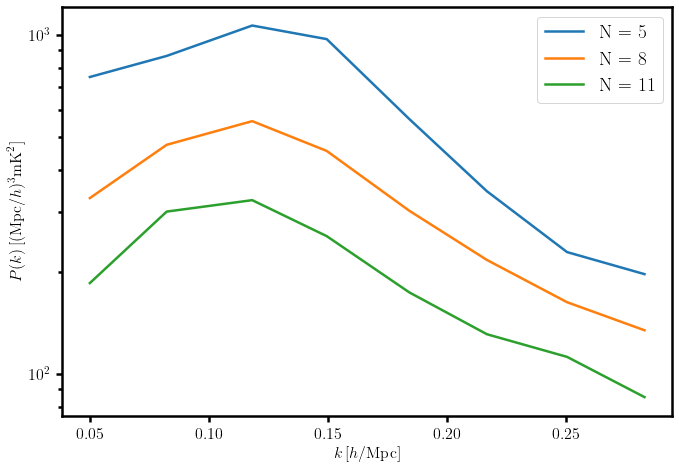

In [33]:
Nlist = [5,8,11]

fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(3, 2, width_ratios=[1, 0.03], height_ratios=[1, 0.1, 1])
ax = fig.add_subplot(gs[:, 0])

for nn,i in zip(Nlist,range(len(Nlist))):
    N_chosen = nn

    A_tmp    = np.copy(AA[:,:N_chosen])   #np.copy(A_pca[:,:N_chosen])
    
    fg_tmp = PCA.fg_est(dTsky,N_chosen)
    res_tmp = PCA.clean(Tsky_shaped,fg_tmp)
    res_tmp = PCA.shaping(res_tmp)*1e3
    #res_tmp  = (BSS.residuals(A_tmp,Tsky))*1e3
    k,pk_HI,dumb0,dumb1,dumb2,nmodes = pk_scripts.pk_quickfunc(res_tmp,*arg)
    del A_tmp,dumb0,dumb1,dumb2
    ax.plot(k,pk_HI,label='N = '+str(nn))   #i took out the k**2 here 
    del k,pk_HI
    
print(nmodes)

ax.set(yscale='log',xlabel=r'$k\,[h/{\rm Mpc}]$',ylabel=r'$ P(k)\,[({\rm Mpc}/h)^3{\rm mK}^2]$');
ax.legend();
#fig.savefig('plots/meerkat-pk.png')